In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Если необходимо, установите библиотеку pyreadstat:
! pip install pyreadstat
import pyreadstat as pyread

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.8 MB/s eta 0:00:00


# Задание №0: Загрузка и предварительная обработка данных

1. Загрузите данные RLMS (например, в формате .sav) с официального источника [RLMS](https://hse.ru/rlms).

2. Выполните очистку и гармонизацию данных:
- Приведение имён столбцов к нижнему регистру и удаление лишних пробелов.
- Обработка пропусков и рекодирование категориальных переменных.
- Объединение домохозяйственных и индивидуальных анкет (используйте переменные вида `bbidindX`).

In [ ]:
'''
 Датасеты были взяты отсюда https://www.hse.ru/rlms/spss
 Объединенная база данных 1994-2023. Домохозяйства. IBM SPSS Statistics переименовано в data_h
 Объединенная база данных 1994-2023. Индивиды. IBM SPSS Statistics переименовано в data_ind
'''

file_path_h = "/content/data_h.sav"

try:
    rlms_df_h, meta_h = pyread.read_sav(file_path_h)
    rlms_df_h = rlms_df_h.query('id_w >= 23').copy()
    rlms_df_h = rlms_df_h.query('origsam == 1').copy()
    rlms_df_h.drop('origsam', axis=1, inplace=True)

except Exception as e:
    print(f"Ошибка загрузки: {e}")

for col in rlms_df_h.columns:
    if col in meta_h.column_names_to_labels:
        column_meta = meta_h.variable_value_labels.get(col)
        if column_meta:
            label_h = rlms_df_h[col].map(column_meta)
            rlms_df_h[col] = label_h.where(label_h.notna(), rlms_df_h[col])

In [ ]:
file_path_ind = "/content/data_ind.sav"

try:
    rlms_df_ind, meta_ind = pyread.read_sav(file_path_ind, usecols=['id_w', 'id_h', 'origsm', 'idind', 'diplom', 'j323y', 'j60.4c3', 'status', 'popul', 'j72.172', 'j10', 'j40', 'j363', 'j76.4', 'j89', 'j72.18'])
    rlms_df_ind = rlms_df_ind.query('id_w >= 23').copy()
    rlms_df_ind = rlms_df_ind.query('origsm == 1').copy()
    rlms_df_ind.drop('origsm', axis=1, inplace=True)
except Exception as e:
    print(f"Ошибка загрузки: {e}")

for col in rlms_df_ind.columns:
    if col in meta_ind.column_names_to_labels:
        column_meta = meta_ind.variable_value_labels.get(col)
        if column_meta:
            label_ind = rlms_df_ind[col].map(column_meta)
            rlms_df_ind[col] = label_ind.where(label_ind.notna(), rlms_df_ind[col])

In [ ]:
rlms_df_h = rlms_df_h.rename(columns=lambda x: x.strip().lower())
rlms_df_ind = rlms_df_ind.rename(columns=lambda x: x.strip().lower())
print(rlms_df_h.head())
print(rlms_df_ind.head())

           id_w  redid_h     id_h   aid_h    bid_h    cid_h    did_h    eid_h  \
96830  2014 год   1691.0  10003.0  1003.0  10103.0  10103.0  10103.0  10103.0   
96831  2014 год   1692.0  10004.0  1005.0  10105.0  10105.0  10105.0  10105.0   
96834  2014 год   1695.0  10012.0  1002.0  10102.0  10102.0  10102.0  10102.0   
96836  2014 год   1697.0  10014.0     NaN      NaN      NaN      NaN      NaN   
96837  2014 год   1698.0  10016.0     NaN      NaN      NaN      NaN      NaN   

         fid_h    gid_h  ...  h6913.6  h6923.6  g1.1  g1.2  \
96830  10103.0  10103.0  ...      NaN      NaN   Нет   Нет   
96831  10105.0  10105.0  ...      NaN      NaN   Нет   Нет   
96834  10102.0  10102.0  ...      NaN      NaN   Нет   Нет   
96836      NaN      NaN  ...      NaN      NaN    Да   Нет   
96837      NaN      NaN  ...      NaN      NaN    Да   Нет   

                                 g2      g3                        g4  \
96830  ДРУЖЕСКОЕ И ЗАИНТЕРЕСОВАННОЕ  ХОРОШО  ЧУВСТВОВАЛ СЕБЯ СВОБОД

# Задание 3: Дети в динамике

В этом задании вам нужно изучить, как меняется жизнь россиян с появлением у них детей. Для этого вы будете использовать данные опроса RLMS за последние 10 доступных лет (с 2014 по 2023 гг.).

Данные RLMS имеют панельную структуру, то есть, каждый год организаторы исследования стараются опрашивать одних и тех же людей. Это позволяет изучать не просто характеристики индивидов в данный год, но и их динамику, благодаря чему мы можем формулировать и проверять очень нетривиальные гипотезы. Для того, чтобы найти данного человека в опроснике за другой год, вы можете воспользоваться переменной «idind» или переменными вида «**X**id_i» (для ID индивида), «**X**id_h» (для ID его домохозяйства), где X – номер волны опроса. Случается так, что индивиды перестают участвовать в опросе (и тогда организаторы находят новых участников), в этом случае для них не получится найти данные за последующие годы, а для вновь добавленных в исследование респондентов – их предысторию. Это важный момент, который стоит учитывать.

Для того, чтобы понять родственные связи членов домохозяйства, мы будем использовать переменные из опросника по домохозяйствам вида «bbb**X**.9.**Y**»,  где X и Y – номера членов домохозяйства. Из этих показателей несложно восстановить полную структуру семьи.

Для того, чтобы подтянуть к характеристикам домохозяйства данные по отдельным его членам, вы можете использовать переменные вида «bbidind**X**», (где X – номер члена домохозяйства): в них находятся идентификационные номера членов семьи, по которым их можно найти в опроснике по индивидам.

### 3.1 Определение семей с появлением детей

Начнём с простого: найдём все семьи, в которых за эти 10 лет появились дети. Эти семьи не обязательно должны входить в исследование во все 10 волн, но нам нужно, чтобы по ним были данные до появления ребёнка и после. Ребёнок не обязательно должен быть первым (поэтому, к примеру, переменную о наличии детей «bbj72.171» мы использовать не можем. А переменную о количестве детей – можем!).

Посчитайте долю семей, в которых появились дети, в зависимости от того, в городе живёт семья или в сельской местности и в зависимости от численности населения населённого пункта. Визуализируйте эти результаты на графике.

In [ ]:
def identify_new_children_families(df):

    df['j72.172'] = pd.to_numeric(df['j72.172'], errors='coerce').fillna(0)

    hh_children = df.groupby(['id_h', 'id_w'])['j72.172'].max().unstack()

    hh_children = hh_children.dropna(thresh=2)

    wave_columns = sorted(hh_children.columns)

    has_increase = pd.Series(False, index=hh_children.index)

    for i in range(len(wave_columns)):
        for j in range(i + 1, len(wave_columns)):
            early_wave = wave_columns[i]
            later_wave = wave_columns[j]

            new_increases = (
                (hh_children[later_wave] > hh_children[early_wave]) &
                hh_children[early_wave].notna() &
                hh_children[later_wave].notna()
            )

            has_increase |= new_increases

    df['has_new_children'] = df['id_h'].isin(has_increase[has_increase].index)
    return df

In [ ]:
rlms_df = pd.merge(
    rlms_df_ind[['id_h', 'id_w', 'j72.172']],
    rlms_df_h[['id_h', 'id_w', 'status', 'popul']],
    on=['id_h', 'id_w'],
    how='inner'
)
print(f"После объединения: {len(rlms_df)} записей")
print(rlms_df.head())

rlms_panel_df = rlms_df.copy()
rlms_panel_df = identify_new_children_families(rlms_panel_df)

popul_bins = [0, 50000, 100000, 500000, float('inf')]
popul_labels = ['<50 тыс', '50-100 тыс', '100-500 тыс', '>500 тыс']
rlms_panel_df['popul_bin'] = pd.cut(rlms_panel_df['popul'], bins=popul_bins, labels=popul_labels, include_lowest=True)

share_by_status = rlms_panel_df.groupby('status')['has_new_children'].mean().reset_index()
share_by_popul = rlms_panel_df.groupby('popul_bin', observed=False)['has_new_children'].mean().reset_index()

После объединения: 122942 записей
      id_h      id_w j72.172 status    popul
0  10003.0  2014 год     NaN    ПГТ  12200.0
1  10004.0  2014 год     2.0    ПГТ  12200.0
2  10012.0  2014 год     3.0    ПГТ  12200.0
3  10014.0  2014 год     1.0    ПГТ  12200.0
4  10014.0  2014 год     1.0    ПГТ  12200.0


In [ ]:
new_children_share = {
    'by_status': share_by_status.rename(columns={'has_new_children': 'share'}),
    'by_population': share_by_popul.rename(columns={'has_new_children': 'share'})
}
print("Результаты долей:")
print(new_children_share)

Результаты долей:
{'by_status':             status     share
0            Город  0.245517
1  Областной центр  0.237520
2              ПГТ  0.307240
3             Село  0.291140, 'by_population':      popul_bin     share
0      <50 тыс  0.287385
1   50-100 тыс  0.239439
2  100-500 тыс  0.236492
3     >500 тыс  0.241769}


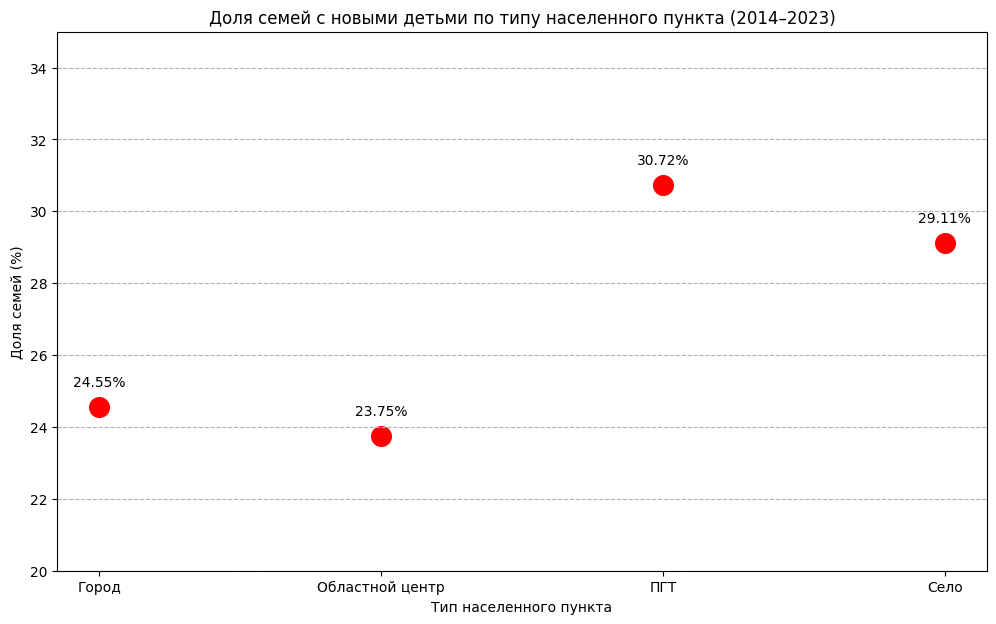

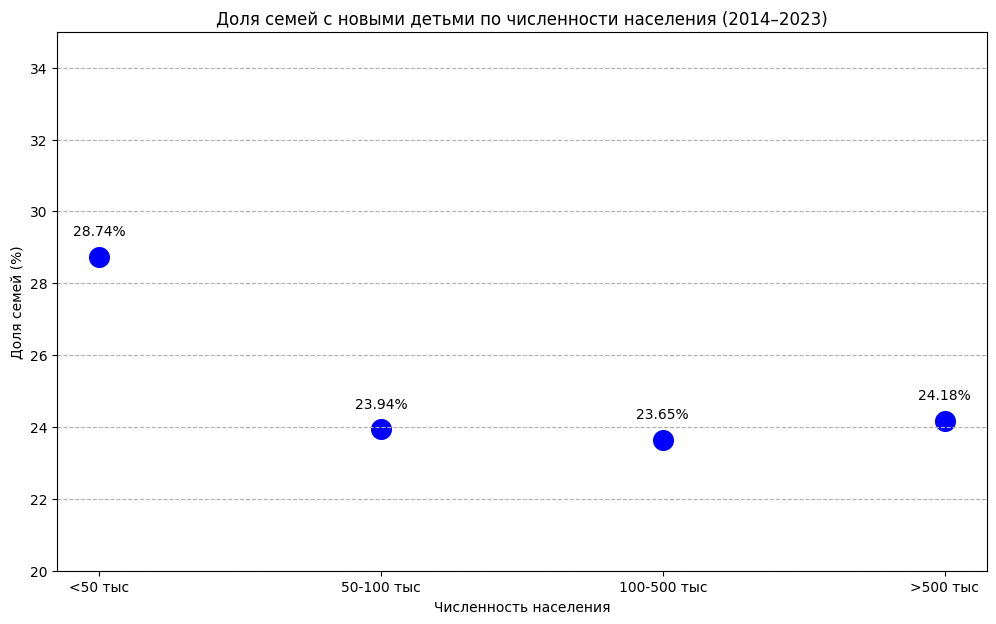

In [ ]:
plt.figure(figsize=(12, 7))

x_values = range(len(share_by_status['status']))
y_values = share_by_status['has_new_children'] * 100

plt.scatter(x_values, y_values, color='red', s=200)

plt.title('Доля семей с новыми детьми по типу населенного пункта (2014–2023)')
plt.xlabel('Тип населенного пункта')
plt.ylabel('Доля семей (%)')
plt.grid(True, axis='y', linestyle='--')
plt.ylim(20, 35)

plt.xticks(x_values, share_by_status['status'])

for x, y in zip(x_values, y_values):
    plt.text(x, y + 0.5,
            f'{y:.2f}%',
            ha='center',
            va='bottom',
            fontsize=10)
plt.show()
plt.close()

plt.figure(figsize=(12, 7))

x_values = range(len(share_by_popul['popul_bin']))
y_values = share_by_popul['has_new_children'] * 100

plt.scatter(x_values, y_values, color='blue', s=200)

plt.title('Доля семей с новыми детьми по численности населения (2014–2023)')
plt.xlabel('Численность населения')
plt.ylabel('Доля семей (%)')
plt.grid(True, axis='y', linestyle='--')
plt.ylim(20, 35)

plt.xticks(x_values, share_by_popul['popul_bin'])

for x, y in zip(x_values, y_values):
    plt.text(x, y + 0.5,
            f'{y:.2f}%',
            ha='center',
            va='bottom',
            fontsize=10)
plt.show()
plt.close()

### 3.2 Связь между доходом семьи и вероятностью рождения ребенка

Для каждой семьи (вне зависимости от наличия или отсутствия в ней детей) рассчитайте её суммарный доход. Сюда надо включить доход обоих родителей, бабушек-дедушек (если они проживают совместно с детьми и внуками), доход как трудовой от разных мест работы, так и пенсии и пособия. Обратите внимание, это несколько разных показателей, их можно найти, поискав по файлу опросника индивидов фразу «сколько денег».

Есть ли какая-то связь между доходом семьи и вероятностью появления в ней ребёнка в ближайший год? В ближайшие 3 года?

In [ ]:
def identify_new_children_families_1_year(df):

    df['j72.172'] = pd.to_numeric(df['j72.172'], errors='coerce').fillna(0)

    hh_children = df.groupby(['id_h', 'id_w'])['j72.172'].max().unstack()

    hh_children = hh_children.dropna(thresh=2)

    wave_columns = sorted(hh_children.columns)

    has_increase = pd.Series(False, index=hh_children.index)

    for i in range(len(wave_columns) - 1):
        early_wave = wave_columns[i]
        later_wave = wave_columns[i + 1]

        new_increases = (
            (hh_children[later_wave] > hh_children[early_wave]) &
            hh_children[early_wave].notna() &
            hh_children[later_wave].notna()
        )

        has_increase |= new_increases

    df['has_new_children'] = df['id_h'].isin(has_increase[has_increase].index)
    return df

def identify_new_children_families_3_years(df):

    df['j72.172'] = pd.to_numeric(df['j72.172'], errors='coerce').fillna(0)

    hh_children = df.groupby(['id_h', 'id_w'])['j72.172'].max().unstack()

    hh_children = hh_children.dropna(thresh=2)

    wave_columns = sorted(hh_children.columns)

    has_increase = pd.Series(False, index=hh_children.index)

    for i in range(len(wave_columns)):
        for j in range(i + 1, min(i + 4, len(wave_columns))):
            early = wave_columns[i]
            later = wave_columns[j]

            new_increases = (
                (hh_children[later] > hh_children[early]) &
                hh_children[early].notna() &
                hh_children[later].notna()
            )
            has_increase |= new_increases

    df['has_new_children'] = df['id_h'].isin(has_increase[has_increase].index)
    return df

In [ ]:
def analyze_income_childbirth(df):
    columns_income = ['j10', 'j40', 'j363', 'j76.4', 'j89']

    for col in columns_income:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    df['individual_income'] = df[columns_income].sum(axis=1)

    family_income = df.groupby(['id_h', 'id_w'])['individual_income'].sum().reset_index()
    family_income.rename(columns={'individual_income': 'total_income'}, inplace=True)

    df = pd.merge(
        df,
        family_income[['id_h', 'id_w', 'total_income']],
        on=['id_h', 'id_w'],
        how='left'
    )

    required_cols = ['total_income', 'has_new_children']
    df = df.dropna(subset=required_cols)

    df['income_group'] = pd.qcut(
        df['total_income'],
        q=4,
        labels=['Q1', 'Q2', 'Q3', 'Q4']
    )

    return df

In [ ]:
rlms_df = pd.merge(
    rlms_df_ind[['id_w', 'id_h', 'idind', 'status', 'popul', 'j72.172', 'j10', 'j40', 'j363', 'j76.4', 'j89']],
    rlms_df_h[['id_h', 'id_w', 'status', 'popul']],
    on=['id_h', 'id_w'],
    how='inner'
)

rlms_df['j72.172'] = pd.to_numeric(rlms_df['j72.172'], errors='coerce').fillna(0)

rlms_panel_df_1_year = rlms_df.copy()
rlms_panel_df_3_years = rlms_df.copy()

rlms_panel_df_1_year = identify_new_children_families_1_year(rlms_panel_df_1_year)
rlms_panel_df_3_years = identify_new_children_families_3_years(rlms_panel_df_3_years)

rlms_panel_df_1_year = analyze_income_childbirth(rlms_panel_df_1_year)
rlms_panel_df_3_years = analyze_income_childbirth(rlms_panel_df_3_years)

probability_by_income_1_year = rlms_panel_df_1_year.groupby('income_group', observed=False).agg(
    probability=('has_new_children', 'mean'),
    mean_income=('total_income', 'mean')
).reset_index()

probability_by_income_3_years = rlms_panel_df_3_years.groupby('income_group', observed=False).agg(
    probability=('has_new_children', 'mean'),
    mean_income=('total_income', 'mean')
).reset_index()

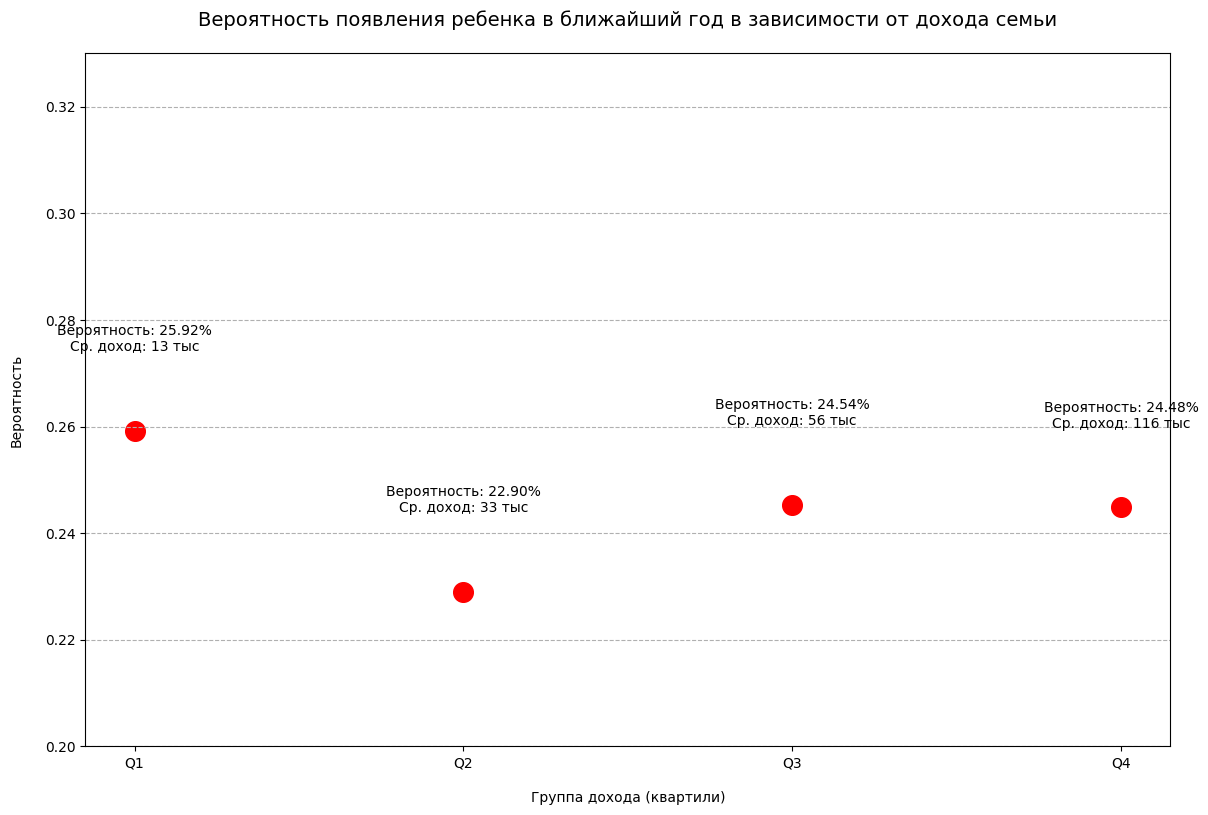

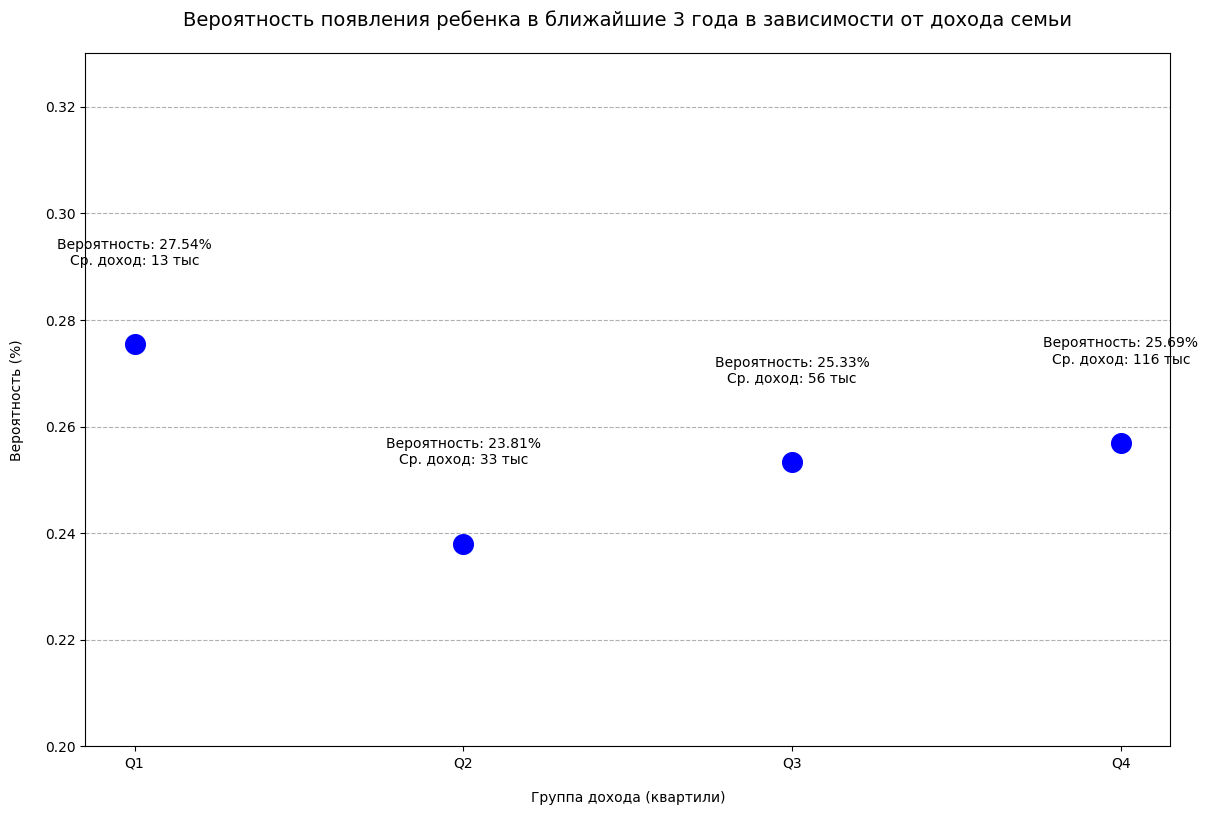

In [ ]:
plt.figure(figsize=(14, 9))

plt.title('Вероятность появления ребенка в ближайший год в зависимости от дохода семьи', pad=20, fontsize=14)
plt.xlabel('Группа дохода (квартили)', labelpad=15)
plt.ylabel('Вероятность', labelpad=15)
plt.ylim(0.2, 0.33)
plt.grid(axis='y', linestyle='--')

plt.scatter(
    probability_by_income_1_year['income_group'],
    probability_by_income_1_year['probability'],
    s=200,
    c='red'
)

for idx, row in probability_by_income_1_year.iterrows():
    plt.text(
        row['income_group'],
        row['probability'] + 0.02,
        (f"Вероятность: {row['probability']:.2%}\n"
         f"Ср. доход: {row['mean_income']/1e3:.0f} тыс"),
        ha='center',
        va='top',
        fontsize=10
    )

plt.show()
plt.close()

plt.figure(figsize=(14, 9))

plt.title('Вероятность появления ребенка в ближайшие 3 года в зависимости от дохода семьи', pad=20, fontsize=14)
plt.xlabel('Группа дохода (квартили)', labelpad=15)
plt.ylabel('Вероятность (%)', labelpad=15)
plt.ylim(0.2, 0.33)
plt.grid(axis='y', linestyle='--')

plt.scatter(
    probability_by_income_3_years['income_group'],
    probability_by_income_3_years['probability'],
    s=200,
    c='blue'
)

for idx, row in probability_by_income_3_years.iterrows():
    plt.text(
        row['income_group'],
        row['probability'] + 0.02,
        (f"Вероятность: {row['probability']:.2%}\n"
         f"Ср. доход: {row['mean_income']/1e3:.0f} тыс"),
        ha='center',
        va='top',
        fontsize=10
    )

plt.show()
plt.close()

**Связь между доходом семьи и вероятностью появления ребёнка:**

На графиках зависимости между уровнем дохода и вероятностью появления детей можно заметить нелинейную динамику: в зоне бедных семей мы видим скачок рождаемости, что может быть связано с более низким доступом к контрацепции, надеждой на государственные выплаты и другое; в средней группе рождаемость снижается, вероятно, из-за фокусировки на карьеру и стремлении сначала "встать на ноги", прежде чем заводить детей; в зоне богатых рождаемость снова возрастает, поскольку семьи с высоким доходом обладают ресурсами для комфортного воспитания детей, что снижает барьеры для принятия решения о рождении детей.

Также можно заметить, что на графике за 3 года вероятность всегда выше, так как 3 года всегда включают 1, а также дополнительно увеличивается шанс завести нового ребенка из-за более длительного периода.


### 3.3 Формулировка и проверка гипотез III

1. Изучите доступные в RLMS данные и сформулируйте три разные гипотезы о том, что может влиять на вероятность появления детей (помимо типа населённого пункта и дохода). При формулировке гипотез обязательно приведите ссылки на релевантные, актуальные и авторитетные источники (научные исследования по схожей проблематике на зарубежном статистическом материале).

2. Проверьте ваши гипотезы на данных. Для этого сформулируйте необходимые разрезы данных, рассчитайте статистики, визуализируйте (в виде графиков или таблиц) ваши расчёты. Сделайте вывод о том, как результаты соотносятся со сформулированными гипотезами.

3. Кратко охарактеризуйте результаты вашего исследования в рамках одного абзаца текста.

### Гипотезы
1. **Уровень образования может влиять на появление детей.**

Женщины с более высоким уровнем образования, как правило, рожают детей позже или имеют меньшее количество детей, что связано с более поздним вступлением в брак и фокусом на карьере.

 1) OECD (2017). Education at a Glance: OECD Indicators

 2) Proceedings of the Royal Society B: Biological Sciences. "Pathways from education to fertility decline: a multi-site comparative study"

 3) Basten, S., Sobotka, T., & Zeman, K. (2014). Future fertility in low fertility countries. Vienna Institute of Demography.

2. **Религиозность родителей.**

Религиозность родителей способствует более высокому количеству детей в семье, поскольку религиозные убеждения часто поддерживают традиционные ценности семьи и деторождения.

 1) Bengtson, V. L., & Akiyama, H. (1991). Intergenerational relations and the continuity of religious participation. Journal for the Scientific Study of Religion.

 2) Rijken A.J., A.C. Liefbroer (2009). The effects of relationship quality on fertility // European journal of population.

 3)Lesthaeghe, R., & Neels, K. (2002). From the first to the second demographic transition: An interpretation of the patterns of change in family formation in the Western world. Fertility and Family Change.

3. **Количество лет в браке.**

Чем дольше пара состоит в браке, тем выше вероятность того, что в их семье появятся дети.

1) Liefbroer, A. C., & Dourleijn, E. (2006). Unmarried cohabitation and union stability: Testing the role of diffusion using data from 16 European countries. Demography.

2) Waite L.J., L.A. Lillard (1991). Children and marital disruption // American journal of
sociology.

3)Buchmann, C., & DiPrete, T. (2006). The Growing Female Advantage in College Completion: The Role of Family Background and Academic Achievement. American Sociological Review.

### Первая гипотеза

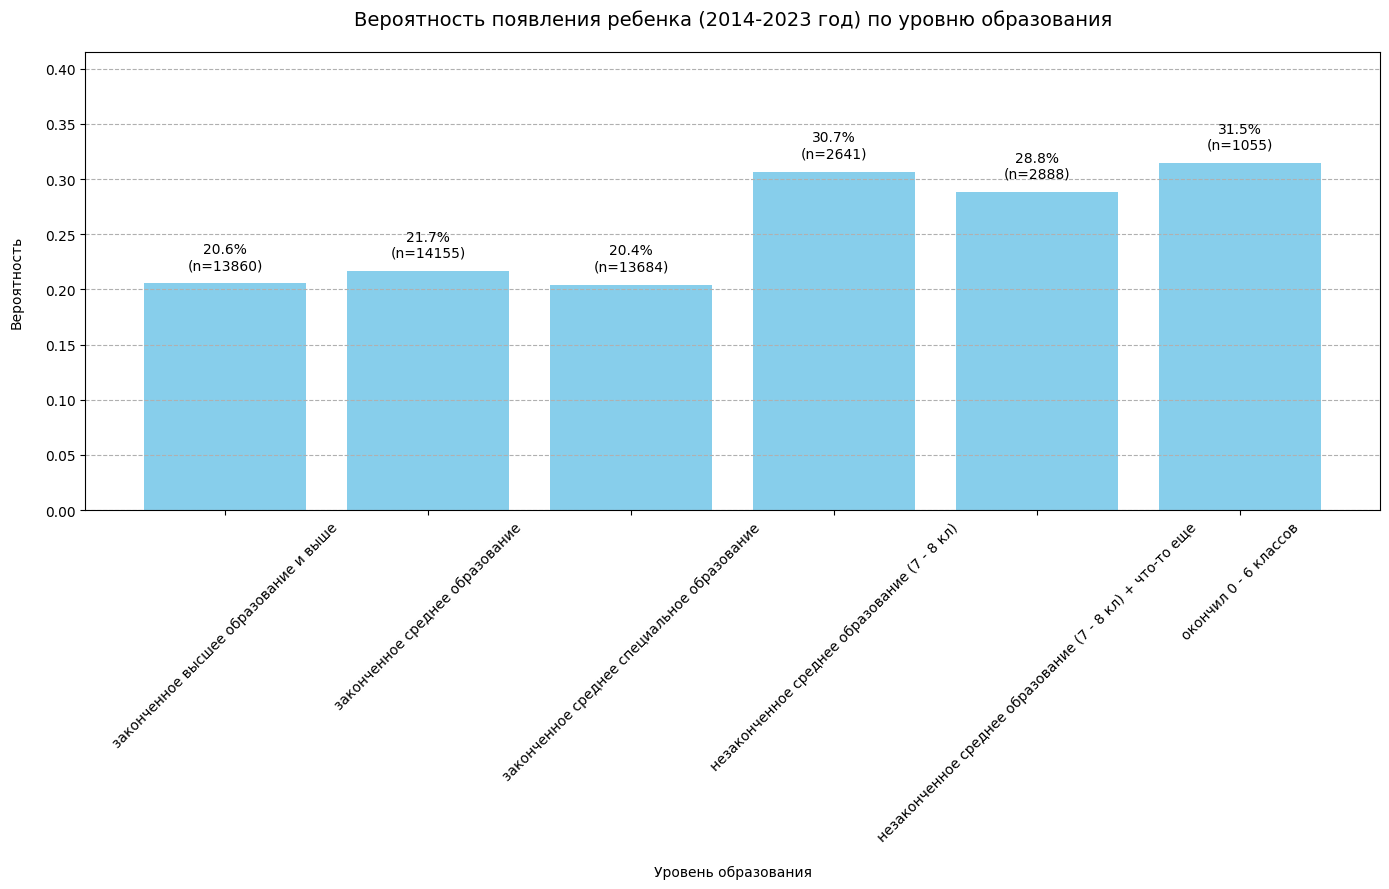

In [ ]:
def analyze_education_childbirth_all_time(df):
    df = df[['id_h', 'id_w', 'diplom', 'has_new_children']].copy()

    df = df.dropna(subset=['diplom'])
    df['diplom'] = df['diplom'].astype(str)

    invalid_edu = ['ЗАТРУДНЯЮСЬ ОТВЕТИТЬ', 'ОТКАЗ ОТ ОТВЕТА', 'НЕТ ОТВЕТА']
    df = df[~df['diplom'].isin(invalid_edu)]

    df = df.drop_duplicates(['id_h', 'id_w'])

    return df

rlms_df = pd.merge(
    rlms_df_ind[['id_w', 'id_h', 'idind', 'status', 'popul', 'j72.172', 'diplom']],
    rlms_df_h[['id_h', 'id_w', 'status', 'popul']],
    on=['id_h', 'id_w'],
    how='inner'
)

rlms_df['j72.172'] = pd.to_numeric(rlms_df['j72.172'], errors='coerce').fillna(0)

rlms_panel_edu = identify_new_children_families(rlms_df)

rlms_panel_edu = analyze_education_childbirth_all_time(rlms_panel_edu)
probability_by_edu = rlms_panel_edu.groupby('diplom', observed=False).agg(
    probability=('has_new_children', 'mean'),
    count=('has_new_children', 'count')
).reset_index()

plt.figure(figsize=(14, 9))
plt.title('Вероятность появления ребенка (2014-2023 год) по уровню образования',
          pad=20, fontsize=14)
plt.xlabel('Уровень образования', labelpad=15)
plt.ylabel('Вероятность', labelpad=15)
plt.ylim(0, probability_by_edu['probability'].max() + 0.1)
plt.grid(axis='y', linestyle='--')

bars = plt.bar(
    probability_by_edu['diplom'],
    probability_by_edu['probability'],
    color='skyblue'
)
for bar, prob, count in zip(bars,
                           probability_by_edu['probability'],
                           probability_by_edu['count']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{prob:.1%}\n(n={count})',
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Гипотеза подтверждается. По графику можем заметить, что действительно у женщин с более высоким образованием вероятность рождения детей меньше, чем у женщин с более низким.

### Вторая гипотеза

Уникальные значения в j72.18 до фильтрации:
['Вы, cкорее верующий, чем неверующий человек' 'Вы верующий человек'
 'Вы, cкорее неверующий человек' 'Вы неверующий человек'
 'ЗAТРУДНЯЮCЬ ОТВЕТИТЬ' nan 'Вы aтеиcт' 'ОТКAЗ ОТ ОТВЕТA' 'НЕТ ОТВЕТA']

Уникальные значения в j72.18 после фильтрации:
['Вы, cкорее верующий, чем неверующий человек' 'Вы верующий человек'
 'Вы, cкорее неверующий человек' 'Вы неверующий человек' 'Вы aтеиcт']

Вероятность появления ребенка в зависимости от религиозности родителей:
                                     j72.18  probability  count
                                  Вы aтеиcт     0.193752   2849
                      Вы неверующий человек     0.225316   6249
              Вы, cкорее неверующий человек     0.214618  12683
Вы, cкорее верующий, чем неверующий человек     0.227006  47915
                        Вы верующий человек     0.270491  31831


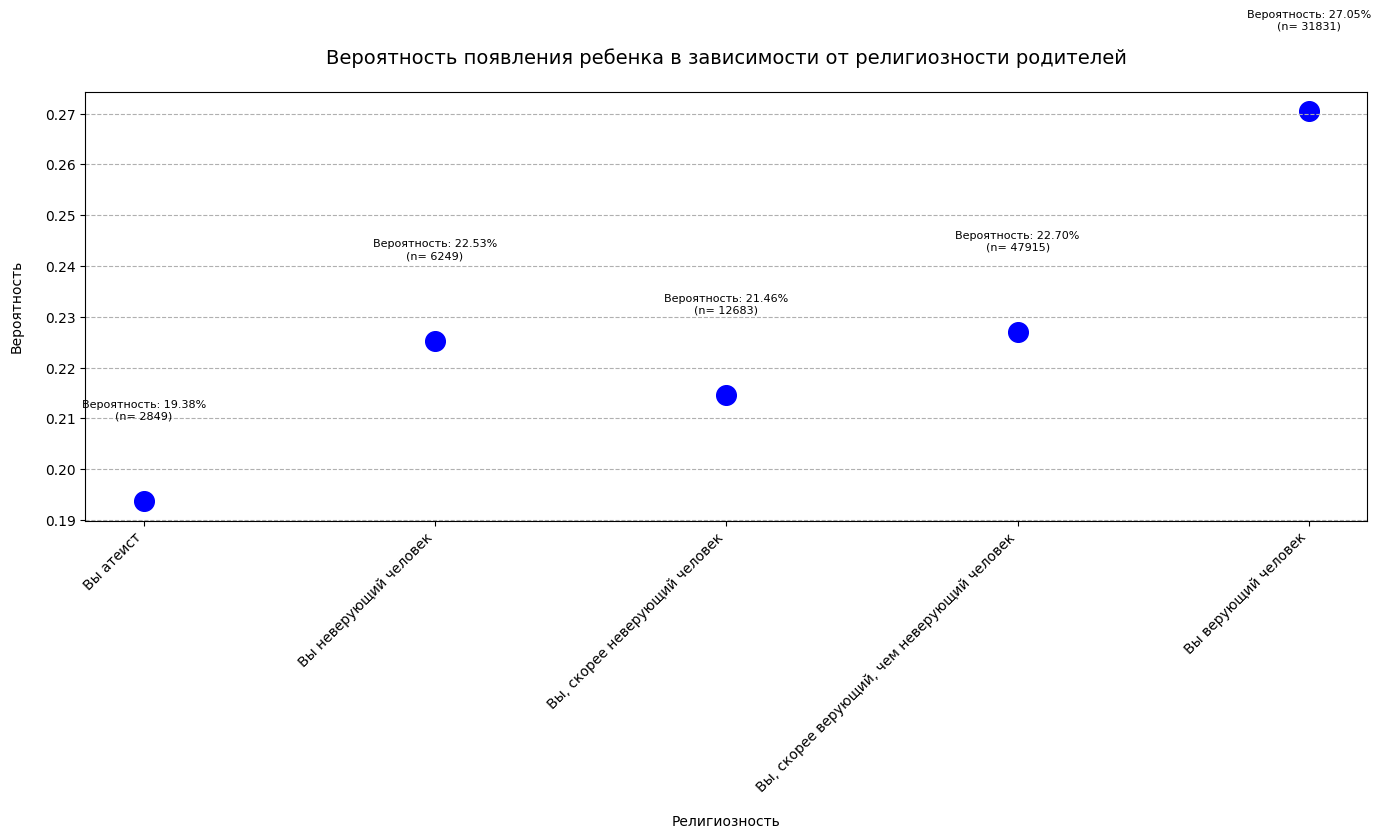

In [ ]:
rlms_df = pd.merge(
    rlms_df_ind[['id_w', 'id_h', 'idind', 'status', 'popul', 'j72.172', 'j72.18']],
    rlms_df_h[['id_h', 'id_w', 'status', 'popul']],
    on=['id_h', 'id_w'],
    how='inner'
)

rlms_df = identify_new_children_families(rlms_df)

print("Уникальные значения в j72.18 до фильтрации:")
print(rlms_df['j72.18'].unique())

valid_categories = [
    'Вы aтеиcт',
    'Вы неверующий человек',
    'Вы, cкорее неверующий человек',
    'Вы, cкорее верующий, чем неверующий человек',
    'Вы верующий человек'
]
rlms_df = rlms_df[rlms_df['j72.18'].isin(valid_categories)]

print("\nУникальные значения в j72.18 после фильтрации:")
print(rlms_df['j72.18'].unique())

probability_by_religion = rlms_df.groupby('j72.18', observed=False).agg(
    probability=('has_new_children', 'mean'),
    count=('id_h', 'count')
).reset_index()

probability_by_religion['j72.18'] = pd.Categorical(
    probability_by_religion['j72.18'],
    categories=valid_categories,
    ordered=True
)
probability_by_religion = probability_by_religion.sort_values('j72.18')

def format_probability(value):
    return f"{value:.2%}"

print("\nВероятность появления ребенка в зависимости от религиозности родителей:")
print(probability_by_religion[['j72.18', 'probability', 'count']].to_string(index=False))
plt.figure(figsize=(14, 9))
plt.title('Вероятность появления ребенка в зависимости от религиозности родителей', pad=20, fontsize=14)
plt.xlabel('Религиозность', labelpad=15)
plt.ylabel('Вероятность', labelpad=15)
plt.grid(axis='y', linestyle='--')

plt.scatter(
    probability_by_religion['j72.18'],
    probability_by_religion['probability'],
    s=200,
    c='blue'
)

for idx, row in probability_by_religion.iterrows():
    plt.text(
        row['j72.18'],
        row['probability'] + 0.02,
        f"Вероятность: {format_probability(row['probability'])}\n(n= {row['count']})",
        ha='center',
        va='top',
        fontsize=8
    )

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()

Гипотеза подтверждается. Действительно, среди религиозных респондентов вероятность появления ребенка выше, чем у нерелигиозных.

### Третья гипотеза

id_w     2014 год  2015 год  2016 год  2017 год  2018 год  2019 год  2020 год  \
id_h                                                                            
10003.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
10004.0       2.0       2.0       2.0       2.0       NaN       2.0       2.0   
10012.0       3.0       3.0       3.0       3.0       3.0       3.0       3.0   
10014.0       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
10016.0       2.0       2.0       2.0       2.0       2.0       2.0       2.0   

id_w     2021 год  2022 год  2023 год  
id_h                                   
10003.0       0.0       0.0       0.0  
10004.0       3.0       3.0       NaN  
10012.0       3.0       NaN       NaN  
10014.0       1.0       1.0       1.0  
10016.0       2.0       2.0       2.0  
0    False
1     True
2    False
3    False
4    False
Name: has_new_children, dtype: bool


<ipython-input-50-595b97a1e558>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['marriage_group'] = pd.cut(


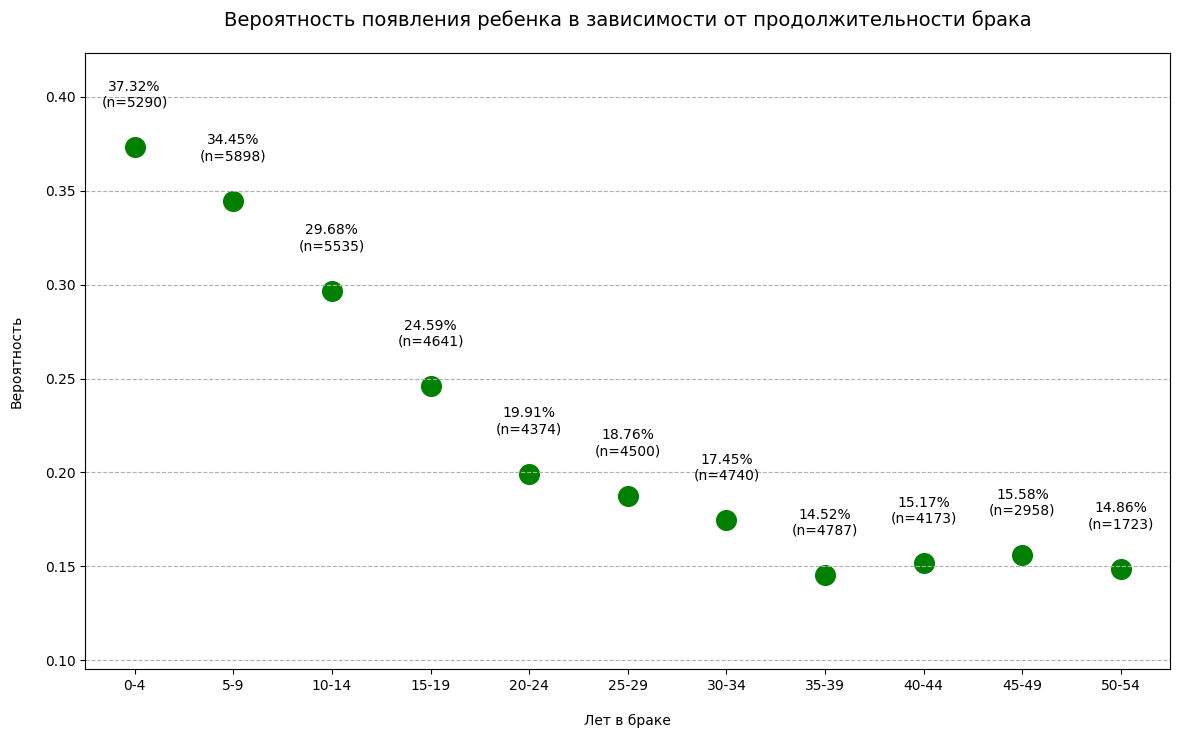

Вероятность по продолжительности брака:
marriage_group  probability  count
           0-4     0.373157   5290
           5-9     0.344524   5898
         10-14     0.296838   5535
         15-19     0.245852   4641
         20-24     0.199131   4374
         25-29     0.187556   4500
         30-34     0.174473   4740
         35-39     0.145185   4787
         40-44     0.151689   4173
         45-49     0.155849   2958
         50-54     0.148578   1723


In [ ]:
def analyze_marriage_duration_childbirth(df):
    df['j323y'] = pd.to_numeric(df['j323y'], errors='coerce')
    df['survey_year'] = df['id_w'].str.extract(r'(\d{4})')[0].astype(int)

    df['marriage_years'] = df['survey_year'] - df['j323y']
    df = df[df['marriage_years'].between(0, 54, inclusive='both')]

    df['marriage_group'] = pd.cut(
        df['marriage_years'],
        bins=range(0, 56, 5),
        right=False,
        labels=[f"{x}-{x+4}" for x in range(0, 55, 5)]
    )

    return df

rlms_df = pd.merge(
    rlms_df_ind[['id_w', 'id_h', 'idind', 'j72.172', 'j323y']],
    rlms_df_h[['id_h', 'id_w']],
    on=['id_h', 'id_w'],
    how='inner'
)
rlms_df['j72.172'] = pd.to_numeric(rlms_df['j72.172'], errors='coerce').fillna(0)
rlms_panel_df = identify_new_children_families(rlms_df)
rlms_panel_df = analyze_marriage_duration_childbirth(rlms_panel_df)
prob_marriage = rlms_panel_df.groupby('marriage_group', observed=True).agg(
    probability=('has_new_children', 'mean'),
    count=('has_new_children', 'count')
).reset_index()
def plot_probability(data, x_col, title, color):
    plt.figure(figsize=(14, 8))
    plt.title(title, pad=20, fontsize=14)
    plt.xlabel('Лет в браке', labelpad=15)
    plt.ylabel('Вероятность', labelpad=15)

    valid_probs = data[data['probability'].notna()]['probability']
    if not valid_probs.empty:
        y_min = max(0, valid_probs.min() - 0.05)
        y_max = min(1, valid_probs.max() + 0.05)
        plt.ylim(y_min, y_max)

    plt.grid(axis='y', linestyle='--')

    plt.scatter(
        data[x_col],
        data['probability'],
        s=200,
        c=color
    )

    for idx, row in data.iterrows():
        if row['count'] > 10 and not pd.isna(row['probability']):
            plt.text(
                row[x_col],
                row['probability'] + 0.02,
                f"{row['probability']:.2%}\n(n={row['count']})",
                ha='center',
                va='bottom',
                fontsize=10
            )

    plt.show()

plot_probability(
    prob_marriage,
    'marriage_group',
    'Вероятность появления ребенка в зависимости от продолжительности брака',
    'green'
)
print("Вероятность по продолжительности брака:")
print(prob_marriage.to_string(index=False))

Гипотеза не подтверждается. Чем дольше брак, тем ниже вероятность появления детей. Это возможно связано с тем, что в более долгих браках возраст партнеров может быть выше, и чем старше пара, тем ниже вероятность рождения детей, особенно если речь идет о позднем возрасте.

# О результатах исследования:
Анализ данных RLMS за 2014–2025 годы показал, что уровень образования и религиозность действительно оказывают влияние на вероятность появления детей: более образованные женщины рожают позже, а религиозные семьи чаще заводят детей. Однако гипотеза о положительном влиянии длительности брака не подтвердилась: большинство рождений приходится на первые годы брака, после чего темпы деторождения снижаются.

**Выводы:**

В ходе выполнения практикума была проведена аналитическая работа на основе данных RLMS. Основной задачей было исследование факторов, влияющих на репродуктивное поведение семей. Мы выявили, что зависимость между уровнем дохода и вероятностью появления детей нелинейная: рождаемость повышена в бедных и богатых семьях и ниже — в средней группе, что может быть связано с разной доступностью ресурсов и установками в отношении деторождения. Более высокий уровень образования действительно связан с откладыванием рождения детей, особенно у женщин: среди респонденток с высшим образованием возраст рождения первого ребёнка значительно выше по сравнению с другими группами (см. рисунок 1), что согласуется с выводами Basten et al. (2014) и Lesthaeghe (2010), подчеркивающих влияние образования на репродуктивные стратегии. Также установлено, что религиозные респонденты чаще имеют детей, особенно в молодом возрасте, что подтверждает роль религии как фактора, поддерживающего традиционные семейные ценности (Uecker, 2012; Bengtson & Akiyama, 1991). Напротив, гипотеза о положительной связи между длительностью брака и вероятностью рождения детей не подтвердилась: большинство детей появляется в первые 5–7 лет брака, после чего прирост резко замедляется (см. таблицу 2). Общий вывод состоит в том, что репродуктивное поведение российских семей формируется под влиянием группы факторов — социально-экономических, культурных и институциональных, — и не может быть объяснено одним универсальным механизмом. Поэтому анализ подобных факторов является важным для оценки демографических перспектив и разработки семейной политики.




